# documents 카테고리 분류

### documents.jsonl 카테고리 확인

In [182]:
category_table_origin_file_path = './data/category_table_origin.jsonl'
category_table_final_file_path ='./data/category_table.jsonl'

documents_file_path = './data/documents.jsonl'
output_file_path = './data/documents_categories.jsonl'

In [173]:
import json
from collections import defaultdict

def get_source_distribution(table_file_path, key):
    category_distribution = defaultdict(int)

    # table에서 정보를 가져옴
    src_to_category = {}
    with open(table_file_path, 'r', encoding='utf-8') as table_file:
        for line in table_file:
            entry = json.loads(line)
            src_to_category[entry['src']] = entry[key]

    # documents에서 src에 맞는 카운트
    total_count = 0

    with open(documents_file_path, 'r', encoding='utf-8') as documents_file:
        for line in documents_file:
            entry = json.loads(line)
            src = entry['src']
            if src in src_to_category:
                category_distribution[src_to_category[src]] += 1
                total_count += 1

    # 결과 출력
    for category, count in category_distribution.items():
        ratio = (count / total_count) * 100 if total_count > 0 else 0
        print(f"{category}: {count} ({ratio:.2f}%)")
        
    return category_distribution


astronomy: 142 (3.32%)
virology: 118 (2.76%)
global_facts: 97 (2.27%)
nutrition: 183 (4.28%)
college_medicine: 111 (2.60%)
college_computer_science: 43 (1.01%)
electrical_engineering: 133 (3.11%)
computer_security: 85 (1.99%)
high_school_biology: 144 (3.37%)
human_sexuality: 92 (2.15%)
conceptual_physics: 237 (5.55%)
ARC_Challenge: 2047 (47.92%)
human_aging: 186 (4.35%)
high_school_physics: 97 (2.27%)
college_biology: 78 (1.83%)
anatomy: 83 (1.94%)
college_physics: 74 (1.73%)
medical_genetics: 86 (2.01%)
college_chemistry: 69 (1.62%)
high_school_chemistry: 130 (3.04%)
high_school_computer_science: 37 (0.87%)


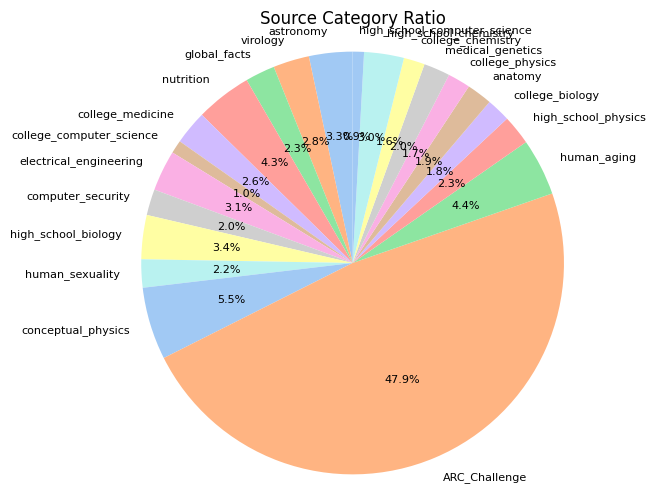

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_ratio(title, category_distribution):
    labels = list(category_distribution.keys())
    sizes = list(category_distribution.values())
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), textprops={'fontsize': 8})
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_category_ratio('Source Category Ratio', get_source_distribution(category_table_origin_file_path, 'src'))

Physics: 550 (12.87%)
Biology: 539 (12.62%)
Global Facts: 97 (2.27%)
Medicine-Health: 741 (17.35%)
Computer Science: 80 (1.87%)
Engineering: 218 (5.10%)
ARC_Challenge: 2047 (47.92%)


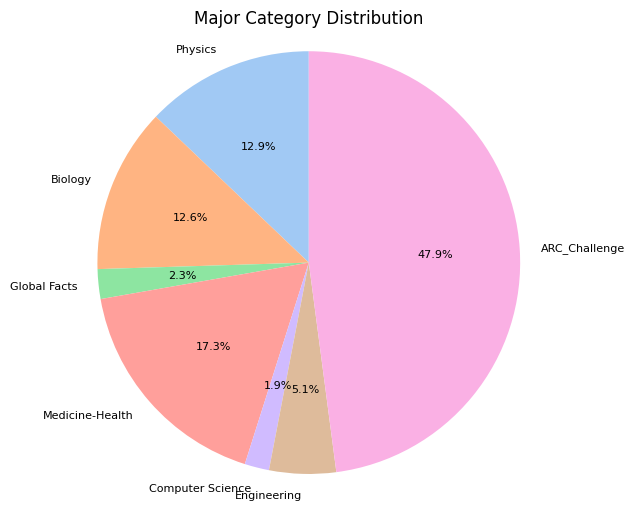

In [175]:
plot_category_ratio('Major Category Distribution', get_source_distribution(category_table_origin_file_path, '대분류'))

physics: 550 (24.72%)
biology: 340 (15.28%)
global_facts: 97 (4.36%)
medicine: 741 (33.30%)
computer_science: 80 (3.60%)
electrical_engineering: 133 (5.98%)
computer_security: 85 (3.82%)
chemistry: 199 (8.94%)


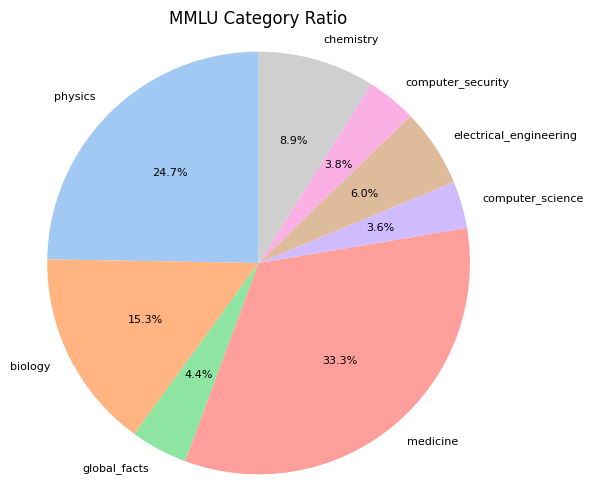

In [176]:
plot_category_ratio('MMLU Category Ratio', get_source_distribution(category_table_final_file_path, '대분류'))

### LLM으로 카테고리 대분류

In [145]:
# 전기공학, 컴퓨터보안을 공학으로 합치면 구분이 잘 안되어서 소스대로 분리
# categories = ["전기공학", "컴퓨터보안", "컴퓨터과학", "물리학", "생물학", "화학", "의학", "지구과학", "과학적방법론", "일반상식"]
categories = ["electrical_engineering", "computer_security", "computer_science", "physics", "biology", "chemistry", "medicine", "earth_science", "scientific_methodology", "global_facts"]

In [ ]:
import transformers
import torch

model_id = "rtzr/ko-gemma-2-9b-it"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)
pipeline.model.eval()

In [147]:
def request_prompt(message, max_new_tokens=100, temperature=None):
    try:
        prompt = pipeline.tokenizer.apply_chat_template(
            message, 
            tokenize=False, 
            add_generation_prompt=True
        )

        terminators = [
            pipeline.tokenizer.eos_token_id,
            pipeline.tokenizer.convert_tokens_to_ids("<end_of_turn>")
        ]

        do_sample = True if temperature else False
        
        outputs = pipeline(
            prompt,
            max_new_tokens=max_new_tokens,
            eos_token_id=terminators,
            do_sample=do_sample,
            temperature=temperature,
        )
        return outputs[0]["generated_text"][len(prompt):]
    except Exception as e:
        print(e)
        return ""

In [148]:
persona = """당신은 과학, 공학 기술에 특화된 상식 RAG 시스템입니다.
입력 문서를 읽고, 카테고리를 지정해주세요. 그리고 연관 있는 카테고리를 최소 1개 추가해주세요.
연관도 높은 순서대로 정렬해서 배열로 반환해주세요.
**카테고리**
0:electrical_engineering, 1:computer_security, 2:computer_science,
3:physics, 4:biology, 5:chemistry, 6:medicine, 7:earth_science, 8:scientific_methodology 
9:global_facts
**입력 예시**
   - 근육 수축은 근육 섬유 내부에서 일어나는 복잡한 과정입니다. 근육 수축 중에는 ...
**출력 예시**: 
   - [5, 3]
**주의사항**:
   - 응답은 반드시 예시처럼 **카테고리 배열** 출력하세요.
"""
print(persona)

당신은 과학, 공학 기술에 특화된 상식 RAG 시스템입니다.
입력 문서를 읽고, 카테고리를 지정해주세요. 그리고 연관 있는 카테고리를 최소 1개 추가해주세요.
연관도 높은 순서대로 정렬해서 배열로 반환해주세요.
**카테고리**
0:electrical_engineering, 1:computer_security, 2:computer_science,
3:physics, 4:biology, 5:chemistry, 6:medicine, 7:earth_science, 8:scientific_methodology 
9:global_facts
**입력 예시**
   - 근육 수축은 근육 섬유 내부에서 일어나는 복잡한 과정입니다. 근육 수축 중에는 ...
**출력 예시**: 
   - [5, 3]
**주의사항**:
   - 응답은 반드시 예시처럼 **카테고리 배열** 출력하세요.



In [ ]:
import json
import re
import gc

def generate_data(input_filename, output_filename, persona, temperature):
    print(f">> {input_filename}")

    with open(input_filename) as f, open(output_filename, "w") as of:
        idx = 0

        for line in f:
            # print(f'[{idx}]')
            if idx > 30:
              break
            
            j = json.loads(line)
            src = j["src"]

            try:
                document = j["content"]
                # print(document)
                prompt = [{"role": "system", "content": persona}] + [{"role": "user", "content": document}]
                # print(f'prompt : {prompt}')
                response = request_prompt(prompt, 16, temperature)
                # print(f'plain : {response}')
                
                selected_categories = [int(num) for num in re.findall(r'\d+', response)]
                selected_category = selected_categories

            except Exception as e:
                id = j["docid"]
                print(f"++ Error! {id} : {e}")
                print(f'plain response : {response}')                

            output = {
                "docid": j["docid"],
                "categories": selected_category,
                "src": src,
                "content": j["content"],
            }
            print(f'{json.dumps(output, ensure_ascii=False)}')

            # 수정된 JSON을 출력 파일에 저장
            of.write(f'{json.dumps(output, ensure_ascii=False)}\n')

            idx += 1

            gc.collect()
            torch.cuda.empty_cache()

output = "./data/documents_categories_index.jsonl"

generate_data(documents_file_path, output, persona, None)

In [ ]:
import json

def process_categories(input_file: str, output_file: str, categories: list) -> dict:
    """
    JSONL 파일의 카테고리를 처리하는 함수
    - 숫자 카테고리를 개별 숫자로 분리
    - 카테고리 인덱스를 카테고리명으로 변환
    
    Args:
        input_file (str): 입력 JSONL 파일 경로
        output_file (str): 출력 JSONL 파일 경로
        categories (list): 카테고리명 리스트
    
    Returns:
        dict: 처리 통계
    """
    total_count = 0
    fixed_count = 0
    converted_count = 0
    error_items = []
    
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        
        for line in infile:
            total_count += 1
            item = json.loads(line.strip())
            
            if 'categories' in item:
                try:
                    # 카테고리 인덱스를 카테고리명으로 변환
                    item['categories'] = [categories[i] for i in item['categories']]
                    converted_count += 1
                    
                except IndexError as e:
                    print(f"\n인덱스 오류 발생 (docid: {item.get('docid', 'unknown')}):")
                    error_index = item['categories'][0]  # 첫 번째 오류 인덱스
                    print(f"오류 인덱스: {error_index}")
                    print(f"원본 항목: {item}")
                    
                    # 숫자를 개별 숫자로 분리
                    if isinstance(error_index, int):
                        digits = [int(d) for d in str(error_index)]
                        # 분리된 숫자를 카테고리명으로 변환
                        try:
                            item['categories'] = [categories[i] for i in digits]
                            fixed_count += 1
                            print(f"수정됨: {digits} -> {item['categories']}")
                        except IndexError:
                            error_items.append(item)
                            print(f"분리 후에도 인덱스 오류 발생: {digits}")
                    
                except Exception as e:
                    print(f"\n예상치 못한 오류 발생 (docid: {item.get('docid', 'unknown')}):")
                    print(f"오류 메시지: {str(e)}")
                    print(f"오류 항목: {item}")
                    error_items.append(item)
            
            # 변환된 항목 저장
            outfile.write(json.dumps(item, ensure_ascii=False) + '\n')
    
    # 처리 통계 출력
    print(f"\n처리 완료:")
    print(f"총 처리 항목: {total_count}")
    print(f"정상 변환: {converted_count}")
    print(f"인덱스 오류 수정: {fixed_count}")
    print(f"처리 실패: {len(error_items)}")
    
    return {
        'total_count': total_count,
        'converted_count': converted_count,
        'fixed_count': fixed_count,
        'error_count': len(error_items),
        'error_items': error_items,
        'output_file': output_file
    }

input_file = output  # 입력 파일 경로
output_file = './data/documents_categories_name.jsonl'  # 출력 파일 경로

result = process_categories(
    input_file=input_file,
    output_file=output_file,
    categories=categories
)


### 검증

##### 카테고리 분류 없는 ARC_Challenge와 카테고리 분류 있는 MMLU 분리

In [ ]:
import json
import os

def separate_jsonl_by_src(input_file, arc_file, mmlu_file):
    """
    Separates a JSONL file into two files based on whether items have src='ARC_Challenge'.
    
    Args:
        input_file (str): Path to input JSONL file
        arc_file (str): Path where ARC_Challenge items will be written
        mmlu_file (str): Path where non-ARC_Challenge items will be written
    
    Returns:
        tuple: Count of items written to each file (arc_count, mmlu_count)
    """
    # Ensure input file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")
    
    # Create output directories if they don't exist
    for file_path in [arc_file, mmlu_file]:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    arc_challenge_items = []
    non_arc_challenge_items = []
    
    # Read the original file
    try:
        with open(input_file, 'r', encoding='utf-8') as infile:
            for line_num, line in enumerate(infile, 1):
                try:
                    item = json.loads(line.strip())
                    if item.get('src') == "ARC_Challenge":
                        arc_challenge_items.append(item)
                    else:
                        non_arc_challenge_items.append(item)
                except json.JSONDecodeError as e:
                    print(f"Warning: Invalid JSON on line {line_num}: {e}")
                    continue
    except Exception as e:
        raise Exception(f"Error reading input file: {e}")
    
    # Write ARC_Challenge items
    try:
        with open(arc_file, 'w', encoding='utf-8') as outfile:
            for item in arc_challenge_items:
                outfile.write(json.dumps(item, ensure_ascii=False) + '\n')
    except Exception as e:
        raise Exception(f"Error writing to ARC file: {e}")
    
    # Write non-ARC_Challenge items
    try:
        with open(mmlu_file, 'w', encoding='utf-8') as outfile:
            for item in non_arc_challenge_items:
                outfile.write(json.dumps(item, ensure_ascii=False) + '\n')
    except Exception as e:
        raise Exception(f"Error writing to MMLU file: {e}")
    
    # Return counts
    return len(arc_challenge_items), len(non_arc_challenge_items)

# Define file paths
input_file = output_file
arc_file = './data/documents_categories_ARC.jsonl'
mmlu_file = './data/documents_categories_MMLU.jsonl'

try:
    arc_count, mmlu_count = separate_jsonl_by_src(input_file, arc_file, mmlu_file)
    print(f"{arc_count:,} items written to {arc_file}")
    print(f"{mmlu_count:,} items written to {mmlu_file}")
    print(f"Total items processed: {arc_count + mmlu_count:,}")
except Exception as e:
    print(f"Error: {e}")

##### MMLU 카테고리와 llm 예측 결과 비교

In [ ]:
import json
from typing import Dict, Any
from dataclasses import dataclass
from pathlib import Path

@dataclass
class CategoryAnalysis:
    """카테고리 분석 결과를 저장하는 클래스"""
    total_items: int = 0
    matching_count: int = 0
    mismatching_count: int = 0
    category_in_list_count: int = 0
    missing_categories_count: int = 0
    missing_src_count: int = 0

    def get_summary(self) -> dict:
        """분석 결과 요약을 반환"""
        total = self.total_items or 1  # Avoid division by zero
        return {
            "총 항목 수": self.total_items,

            "카테고리 일치 항목": f"{self.matching_count} ({self.matching_count/total*100:.2f}%)",
            "카테고리 불일치 항목": f"{self.mismatching_count} ({self.mismatching_count/total*100:.2f}%)",
            
            "대분류가 categories에 포함된 항목": f"{self.category_in_list_count} ({self.category_in_list_count/total*100:.2f}%)",
            "categories 필드 누락 항목": self.missing_categories_count,
            "매핑되지 않은 src 항목": self.missing_src_count
        }

class CategoryAnalyzer:
    """MMLU 카테고리와 문서 카테고리를 분석하는 클래스"""
    
    def __init__(self, table_file: str, document_file: str):
        """
        Args:
            table_file: 카테고리 매핑 테이블 파일 경로
            document_file: 분석할 문서 파일 경로
        """
        self.table_file = Path(table_file)
        self.document_file = Path(document_file)
        self.category_mapping = {}
        self.analysis = CategoryAnalysis()
        
    def load_category_mapping(self) -> None:
        """카테고리 매핑 테이블 로드"""
        try:
            with open(self.table_file, 'r', encoding='utf-8') as f:
                for line in f:
                    item = json.loads(line.strip())
                    self.category_mapping[item['src']] = item['대분류']
        except FileNotFoundError:
            raise FileNotFoundError(f"카테고리 매핑 파일을 찾을 수 없습니다: {self.table_file}")
        except json.JSONDecodeError as e:
            raise ValueError(f"카테고리 매핑 파일 형식이 잘못되었습니다: {e}")

    def analyze_document(self) -> None:
        """문서 분석 수행"""
        try:
            with open(self.document_file, 'r', encoding='utf-8') as f:
                for line in f:
                    self._process_document_line(line)
        except FileNotFoundError:
            raise FileNotFoundError(f"문서 파일을 찾을 수 없습니다: {self.document_file}")

    def _process_document_line(self, line: str) -> None:
        """개별 문서 라인 처리"""
        try:
            item = json.loads(line.strip())
            self.analysis.total_items += 1
            
            if not self._check_src_exists(item):
                return
                
            if not self._check_categories_exist(item):
                return
                
            self._analyze_categories(item)
            
        except json.JSONDecodeError:
            print(f"잘못된 JSON 형식: {line.strip()}")

    def _check_src_exists(self, item: Dict[str, Any]) -> bool:
        """src 필드 존재 여부 확인"""
        src = item.get('src')
        if src not in self.category_mapping:
            self.analysis.missing_src_count += 1
            self.analysis.mismatching_count += 1
            print(f"매핑되지 않은 src: {item.get('docid')} (src: {src})")
            return False
        return True

    def _check_categories_exist(self, item: Dict[str, Any]) -> bool:
        """categories 필드 존재 여부 확인"""
        if 'categories' not in item or not item['categories']:
            self.analysis.missing_categories_count += 1
            self.analysis.mismatching_count += 1
            print(f"categories 필드 누락: {item.get('docid')}")
            return False
        return True

    def _analyze_categories(self, item: Dict[str, Any]) -> None:
        """카테고리 분석 수행"""
        expected_category = self.category_mapping[item['src']]
        actual_category = item['categories'][0]
        matches = actual_category == expected_category
        
        analysis_result = {
            'docid': item['docid'],
            'actual_category': actual_category,
            'expected_category': expected_category,
            'matches': matches,
            'expected_in_categories': expected_category in item['categories']
        }
        print(analysis_result)
        
        if matches:
            self.analysis.matching_count += 1
        else:
            self.analysis.mismatching_count += 1
            
        if expected_category in item['categories']:
            self.analysis.category_in_list_count += 1

def analyze_categories(table_file_path: str, document_file_path: str) -> None:
    """
    카테고리 분석을 실행하는 함수
    
    Args:
        table_file_path: 카테고리 매핑 테이블 파일 경로
        document_file_path: 분석할 문서 파일 경로
    """
    try:
        analyzer = CategoryAnalyzer(table_file_path, document_file_path)
        analyzer.load_category_mapping()
        analyzer.analyze_document()
        
        print("\n=== 분석 결과 요약 ===")
        for key, value in analyzer.analysis.get_summary().items():
            print(f"{key}: {value}")
            
    except Exception as e:
        print(f"오류 발생: {e}")
        raise

# table.jsonl 데이터를 로드하고 비교 수행
analyze_categories(category_table_final_file_path, mmlu_file)

### 보정

##### MMLU 카테고리가 llm 예측에 없으면 0번째 index로 추가

In [ ]:
import json
from pathlib import Path
from typing import Dict, List
from dataclasses import dataclass

@dataclass
class ReconstructionSummary:
    """카테고리 재구성 결과를 저장하는 클래스"""
    total_documents: int = 0
    major_category_added: int = 0
    major_category_reordered: int = 0
    no_changes_needed: int = 0
    
    def get_summary(self) -> Dict[str, str]:
        return {
            "총 처리된 문서": f"{self.total_documents:,}개",
            "대분류 추가됨": f"{self.major_category_added:,}개 ({self.get_percentage(self.major_category_added)}%)",
            "대분류 위치 조정됨": f"{self.major_category_reordered:,}개 ({self.get_percentage(self.major_category_reordered)}%)",
            "변경 불필요": f"{self.no_changes_needed:,}개 ({self.get_percentage(self.no_changes_needed)}%)"
        }
    
    def get_percentage(self, value: int) -> float:
        """백분율 계산"""
        return round((value / self.total_documents * 100), 2) if self.total_documents > 0 else 0

class CategoryReconstructor:
    def __init__(self, doc_file: str, category_mapping_file: str):
        self.doc_file = Path(doc_file)
        self.category_mapping_file = Path(category_mapping_file)
        self.category_mapping = {}
        self.summary = ReconstructionSummary()
        self.modified_documents: List[Dict] = []
    
    def load_category_mapping(self) -> None:
        """카테고리 매핑 파일 로드"""
        try:
            with open(self.category_mapping_file, 'r', encoding='utf-8') as f:
                for line in f:
                    item = json.loads(line.strip())
                    self.category_mapping[item['src']] = item['대분류']
        except FileNotFoundError:
            raise FileNotFoundError(f"카테고리 매핑 파일을 찾을 수 없습니다: {self.category_mapping_file}")
        except json.JSONDecodeError as e:
            raise ValueError(f"카테고리 매핑 파일 형식이 잘못되었습니다: {e}")

    def process_file(self) -> None:
        """파일 처리 및 수정"""
        try:
            # 파일 읽기
            with open(self.doc_file, 'r', encoding='utf-8') as f:
                for line in f:
                    document = json.loads(line.strip())
                    self.process_document(document)
            
            # 수정된 내용 저장
            self._save_modified_documents()
            
        except FileNotFoundError:
            raise FileNotFoundError(f"파일을 찾을 수 없습니다: {self.doc_file}")
        except json.JSONDecodeError as e:
            raise ValueError(f"잘못된 JSON 형식: {e}")
    
    def process_document(self, document: Dict) -> None:
        """개별 문서 처리"""
        self.summary.total_documents += 1
        
        if 'src' not in document:
            print(f"Warning: src 필드가 없는 문서 발견 (docid: {document.get('docid', 'unknown')})")
            self.modified_documents.append(document)
            return
            
        src_value = document['src']
        major_category = self.category_mapping.get(src_value)
        
        if not major_category:
            print(f"Warning: src에 대한 대분류가 없는 문서 발견 (docid: {document.get('docid', 'unknown')})")
            self.modified_documents.append(document)
            return

        if 'categories' not in document:
            document['categories'] = []

        categories = document['categories']
        
        if major_category not in categories:
            # 대분류가 categories에 없는 경우, 추가
            categories.insert(0, major_category)
            self.summary.major_category_added += 1
        elif categories[0] != major_category:
            # 대분류가 첫 번째가 아닌 경우
            categories.remove(major_category)
            categories.insert(0, major_category)
            self.summary.major_category_reordered += 1
        else:
            # 이미 올바른 위치에 있는 경우
            self.summary.no_changes_needed += 1
        
        document['categories'] = categories
        self.modified_documents.append(document)
    
    def _save_modified_documents(self) -> None:
        """수정된 문서 저장"""
        backup_path = self.doc_file.with_suffix('.jsonl.backup')
        
        # 기존 파일 백업
        if self.doc_file.exists():
            self.doc_file.rename(backup_path)
        
        # 수정된 내용 저장
        with open(self.doc_file, 'w', encoding='utf-8') as f:
            for doc in self.modified_documents:
                f.write(json.dumps(doc, ensure_ascii=False) + '\n')

def reconstruct_categories(doc_file: str, category_mapping_file: str) -> None:
    try:
        print("카테고리 재구성 시작...")
        reconstructor = CategoryReconstructor(doc_file, category_mapping_file)
        reconstructor.load_category_mapping()
        reconstructor.process_file()
        
        print("\n=== 처리 결과 요약 ===")
        for key, value in reconstructor.summary.get_summary().items():
            print(f"{key}: {value}")
        
        print(f"\n원본 파일이 {doc_file}.backup으로 백업되었습니다.")
        
    except Exception as e:
        print(f"오류 발생: {e}")
        raise

# 카테고리 재구성 실행
reconstruct_categories(mmlu_file, category_table_final_file_path)

##### 연관 카테고리가 없는 아이템에 빈도수 높은 카테고리 붙여주기

In [154]:
import json
from collections import defaultdict
from typing import List, Dict, Set, Tuple
import copy
from datetime import datetime

def load_jsonl(file_path: str) -> List[dict]:
    """JSONL 파일을 불러오는 함수"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def save_jsonl(data: List[dict], file_path: str):
    """JSONL 파일로 저장하는 함수"""
    with open(file_path, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

def analyze_category_pairs(data: List[dict]) -> Dict[str, Dict[str, int]]:
    """각 카테고리와 함께 등장하는 다른 카테고리의 분포를 분석하는 함수"""
    category_pairs = defaultdict(lambda: defaultdict(int))
    
    for item in data:
        categories = item['categories']
        if len(categories) > 1:
            for cat1 in categories:
                for cat2 in categories:
                    if cat1 != cat2:
                        category_pairs[cat1][cat2] += 1
    
    return category_pairs

def get_most_common_pair(category: str, pair_distribution: Dict[str, Dict[str, int]]) -> Tuple[str, int]:
    """특정 카테고리와 가장 자주 함께 등장하는 카테고리와 그 빈도수를 찾는 함수"""
    if category not in pair_distribution:
        return None, 0
    pairs = pair_distribution[category]
    if not pairs:
        return None, 0
    result = max(pairs.items(), key=lambda x: x[1])
    return result[0], result[1]

def print_category_pair_distribution(pair_distribution: Dict[str, Dict[str, int]]):
    """카테고리 페어 분포 출력 함수"""
    print("\n=== 카테고리 페어 분포 ===")
    for category, pairs in pair_distribution.items():
        if pairs:  # 페어가 있는 경우만 출력
            print(f"\n{category}와(과) 함께 등장하는 카테고리:")
            for pair_category, count in sorted(pairs.items(), key=lambda x: x[1], reverse=True):
                print(f"  - {pair_category}: {count}회")

def update_single_categories(data: List[dict], pair_distribution: Dict[str, Dict[str, int]]) -> Tuple[List[dict], List[dict]]:
    """카테고리가 1개인 항목에 가장 연관성 높은 카테고리를 추가하는 함수"""
    updated_data = copy.deepcopy(data)
    update_logs = []
    
    print("\n=== 카테고리 업데이트 상세 내역 ===")
    for item in updated_data:
        if len(item['categories']) == 1:
            current_category = item['categories'][0]
            new_category, frequency = get_most_common_pair(current_category, pair_distribution)
            
            if new_category:
                original_categories = item['categories'].copy()
                item['categories'].append(new_category)
                
                # 업데이트 정보 출력
                print(f"\nDocument ID: {item['docid']}")
                print(f"원본 카테고리: {original_categories}")
                print(f"추가된 카테고리: {new_category}")
                print(f"최종 카테고리: {item['categories']}")
                print(f"사유: Category '{new_category}'가 '{current_category}'와 함께 {frequency}회 등장")
                print("-" * 50)
                
                # 로그 저장
                update_logs.append({
                    'docid': item['docid'],
                    'original_categories': original_categories,
                    'added_category': new_category,
                    'updated_categories': item['categories']
                })
    
    return updated_data, update_logs

def get_category_distribution(data: List[dict]) -> Dict[str, int]:
    """전체 카테고리 분포를 계산하는 함수"""
    distribution = defaultdict(int)
    for item in data:
        for category in item['categories']:
            distribution[category] += 1
    return dict(distribution)

def print_distribution_comparison(original_dist: Dict[str, int], updated_dist: Dict[str, int]):
    """카테고리 분포 비교 출력 함수"""
    print("\n=== 카테고리 분포 변화 ===")
    all_categories = sorted(set(original_dist.keys()) | set(updated_dist.keys()))
    for category in all_categories:
        original = original_dist.get(category, 0)
        updated = updated_dist.get(category, 0)
        diff = updated - original
        diff_str = f"({diff:+d})" if diff != 0 else "(변화 없음)"
        print(f"{category}: {original} → {updated} {diff_str}")

def analyze_and_update_categories(input_file: str, output_file: str) -> dict:
    """전체 분석 및 업데이트 프로세스를 실행하는 메인 함수"""
    print(f"\n작업 시작: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 데이터 로드
    data = load_jsonl(input_file)
    print(f"총 {len(data)}개 문서 로드 완료")
    
    # 카테고리 페어 분석
    pair_distribution = analyze_category_pairs(data)
    print_category_pair_distribution(pair_distribution)
    
    # 원본 카테고리 분포 계산
    original_distribution = get_category_distribution(data)
    
    # 단일 카테고리 항목 업데이트
    updated_data, update_logs = update_single_categories(data, pair_distribution)
    
    # 업데이트된 카테고리 분포 계산
    updated_distribution = get_category_distribution(updated_data)
    
    # 분포 비교 출력
    print_distribution_comparison(original_distribution, updated_distribution)
    
    # 결과 저장
    save_jsonl(updated_data, output_file)
    print(f"\n업데이트된 총 문서 수: {len(update_logs)}")
    print(f"결과가 {output_file}에 저장되었습니다.")
    
    return {
        'pair_distribution': pair_distribution,
        'original_distribution': original_distribution,
        'updated_distribution': updated_distribution,
        'update_logs': update_logs
    }

In [ ]:
# MMLU 업데이트
docu_file = mmlu_file  # documents.jsonl 파일 경로
final_mmlu_output_file = f"{output_file}_add_category"  # 결과를 저장할 새로운 파일 경로
analyze_and_update_categories(docu_file, final_mmlu_output_file)

In [ ]:
# ARC 업데이트
docu_file = arc_file
final_arc_output_file = f"{docu_file}_add_category"  # 결과를 저장할 새로운 파일 경로
analyze_and_update_categories(docu_file, final_arc_output_file)

In [ ]:
import json

def merge_jsonl_files(input_files: list, output_file: str) -> dict:
    """
    여러 JSONL 파일을 하나로 병합하는 함수
    
    Args:
        input_files (list): 입력 JSONL 파일 경로 리스트
        output_file (str): 출력 JSONL 파일 경로
    
    Returns:
        dict: 병합 결과 통계
    """
    total_records = 0
    records_by_file = {}
    
    with open(output_file, 'w', encoding='utf-8') as outfile:
        for input_file in input_files:
            record_count = 0
            try:
                with open(input_file, 'r', encoding='utf-8') as infile:
                    for line in infile:
                        # JSON 형식 검증
                        try:
                            json_obj = json.loads(line.strip())
                            outfile.write(line)
                            record_count += 1
                        except json.JSONDecodeError as e:
                            print(f"Warning: Skipping invalid JSON in {input_file}: {e}")
                            continue
                
                records_by_file[input_file] = record_count
                total_records += record_count
                print(f"처리완료: {input_file} - {record_count}개 레코드")
                
            except FileNotFoundError:
                print(f"Error: File not found - {input_file}")
                records_by_file[input_file] = 0
    
    print(f"\n병합 완료: {output_file}")
    print(f"총 레코드 수: {total_records}")
    
    return {
        'total_records': total_records,
        'records_by_file': records_by_file,
        'output_file': output_file
    }

# 병합할 파일 리스트
files_to_merge = [
    final_mmlu_output_file,
    final_arc_output_file
]

result = merge_jsonl_files(files_to_merge, output_file_path)

##### 최종 카테고리 확인

Total Documents Processed: 4272
0th Index Category Distribution:
physics: 977 items (22.87%)
biology: 821 items (19.22%)
global_facts: 104 items (2.43%)
medicine: 785 items (18.38%)
computer_science: 132 items (3.09%)
electrical_engineering: 482 items (11.28%)
computer_security: 88 items (2.06%)
chemistry: 399 items (9.34%)
earth_science: 425 items (9.95%)
scientific_methodology: 59 items (1.38%)


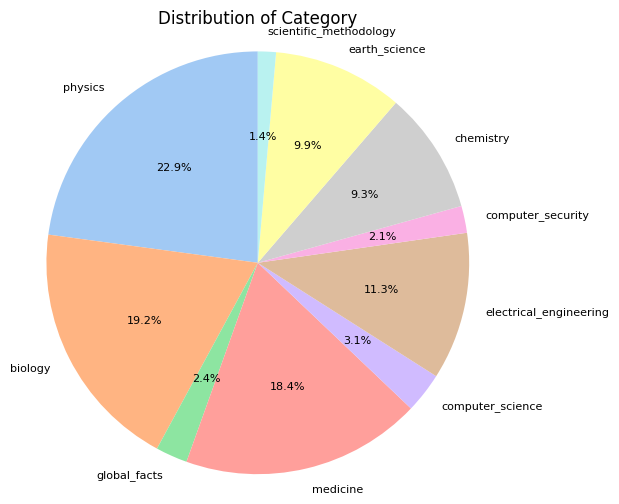

In [183]:
import json
from collections import Counter

# Load JSONL data
categories_count = Counter()

# Count the 0th index category occurrences
with open(output_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        doc = json.loads(line)
        if 'categories' in doc and len(doc['categories']) > 0:
            categories_count[doc['categories'][0]] += 1

# Calculate the distribution percentages
total_docs = sum(categories_count.values())
categories_distribution = {category: (count / total_docs) * 100 for category, count in categories_count.items()}

# Print the results
print(f"Total Documents Processed: {total_docs}")
print("0th Index Category Distribution:")
for category, count in categories_count.items():
    distribution = (count / total_docs) * 100
    print(f"{category}: {count} items ({distribution:.2f}%)")

plot_category_ratio('Distribution of Category', categories_distribution)

Total Categories Counted: 9409
Category Item Distribution:
physics: 2497 items (26.54%)
earth_science: 916 items (9.74%)
biology: 1219 items (12.96%)
global_facts: 299 items (3.18%)
computer_security: 241 items (2.56%)
medicine: 972 items (10.33%)
chemistry: 1224 items (13.01%)
electrical_engineering: 1143 items (12.15%)
computer_science: 583 items (6.20%)
scientific_methodology: 315 items (3.35%)


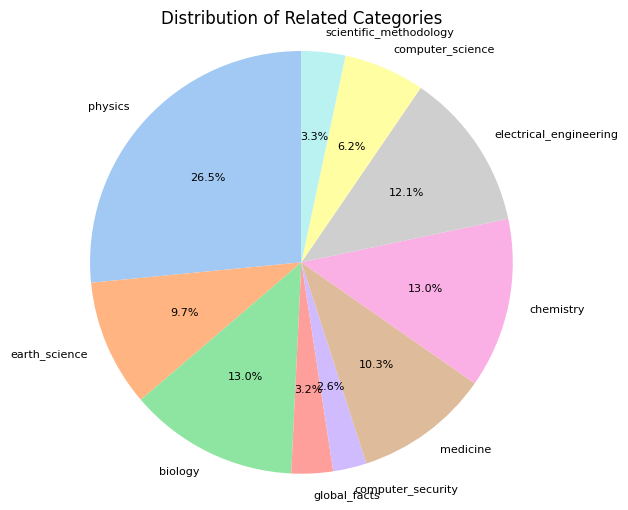

In [185]:
import json
from collections import Counter

# Initialize Counter for all categories
all_categories_count = Counter()

# Count occurrences of each category item in the list
with open(output_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        doc = json.loads(line)
        if 'categories' in doc:
            all_categories_count.update(doc['categories'])

# Calculate the distribution percentages
total_categories = sum(all_categories_count.values())
categories_distribution = {category: (count / total_categories) * 100 for category, count in all_categories_count.items()}

# Print distribution percentages and item counts
print(f"Total Categories Counted: {total_categories}")
print("Category Item Distribution:")
for category, count in all_categories_count.items():
    distribution = (count / total_categories) * 100
    print(f"{category}: {count} items ({distribution:.2f}%)")

plot_category_ratio('Distribution of Related Categories', categories_distribution)